In [1]:
# default_exp multi_armed_bandits

# multi_armed_bandits

> module for generating bandit responses

In [2]:
from nbdev.showdoc import *

import matplotlib.pyplot as plt
%matplotlib inline
from sklearn.utils import shuffle

%load_ext autoreload
%autoreload 2

In [3]:
#export
import numpy as np
import scipy.stats as stats
from thompson_sampling.abstractions import AbstractContextualMAB



def sigmoid(x):
    return 1 / (1 + np.exp(-x))


In [4]:
np.random.seed(42)


In [53]:
theta = [0.1, 0.9]
theta_contextual = [1.6, 0.4]
nonlinear_theta = [1,0.5,1.5]
noise = 0.1
num_data = 100
X_orig = np.linspace(-6, 6, num_data)
X = shuffle(X_orig)
idx = np.argsort(X)

X_multidimensional = np.append(np.atleast_2d(np.linspace(-6, 6, num_data)),
                               np.atleast_2d(np.linspace(10, -2, num_data)),
                               axis=0)

X_multidimensional = np.append(X_multidimensional,
                               np.atleast_2d(np.linspace(10, 5, num_data)),
                               axis=0)
                               
                              


X_multidimensional.shape

(3, 100)

In [54]:
X_multidimensional[:,0]

array([-6., 10., 10.])

## Categorical Features

### noncontextual

In [55]:
#export
def non_contextual_categorical_bandit(choice:int, theta:np.array)->bool:

    # draw a number between 0 and 1, if it's smaller than the theta, return reward
    if np.random.random() < theta[choice]:
        reaction = True
    else:
        reaction = False

    return reaction

In [56]:
y0 = [non_contextual_categorical_bandit(0,theta) for i in range(100)]
y1 = [non_contextual_categorical_bandit(1,theta) for i in range(100)]


np.mean(y0), np.mean(y1)

(0.12, 0.9)

In [57]:
assert non_contextual_categorical_bandit(1,theta) in [True, False]

### linear


In [58]:
#export
def contextual_categorical_bandit(context:np.array, choice:int, theta:np.array, noise:float):
    y = 0
    
    for dim in np.atleast_1d(context):
        y+= theta[choice] * dim
        
    p = sigmoid(y)

    return np.random.choice([0,1],p=[1-p,p]), max(theta) - p, p

def contextual_categorical_get_optimal_arm(context):
    if context < 0:
        return 1
    return 0

In [59]:
contextual_categorical_bandit(context = 10, choice = 1, theta = theta, noise = noise)

(1, -0.09987660542401366, 0.9998766054240137)

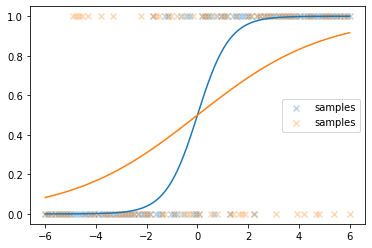

In [60]:
for arm in [0,1]:
    y = []
    p1s = []
    p2s= []
    optimal_y = []
    for i in range(num_data):
        outcome, p1, p2 = contextual_categorical_bandit(X_orig[i],arm,theta_contextual,noise)
        p1s.append(p1)
        p2s.append(p2)
        y.append(outcome)

        optimal_y.append(contextual_categorical_bandit(X_orig[i], contextual_categorical_get_optimal_arm(X_orig[i]), theta_contextual, noise)[0])

    y = np.array(y).flatten()

    plt.scatter(X_orig,y,alpha = 0.3, marker= 'x', label = 'samples',)

    plt.legend()
    plt.plot(X_orig,p2s)

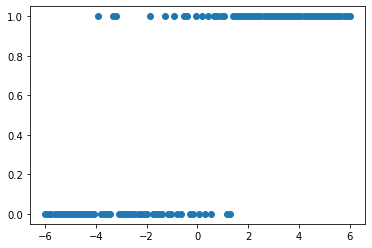

In [61]:
plt.scatter(X_orig, optimal_y)

In [62]:
contextual_categorical_bandit(context = [10,1], choice = 1, theta = theta, noise = noise)

(1, -0.09994982783531614, 0.9999498278353162)

###  nonlinear

In [130]:
#export
class NonlinearContextualCategoricalBandit(AbstractContextualMAB):
    
    def get_probability(self, choice, context):
        y = 0 #self.theta[choice]

        for dim in np.atleast_1d(context):
            y+= np.sin(self.theta[choice] * (dim+1)/2 + dim +  np.random.normal(0,self.noise))

        return self.activation(y)
    
    def get_reward(self, choice, context):
        p = self.get_probability(choice, context)
        return np.random.choice([0,1],p=[1-p,p]), max(self.theta) - p, p
    
    def get_optimal_arm(self, context):
        arm_ps = []
        for i in range(self.num_arms):
            arm_ps.append(self.get_probability(i, context))
            
        return np.argmax(arm_ps)

In [131]:
nccb = NonlinearContextualCategoricalBandit(theta=nonlinear_theta ,noise=noise, linear=False)
nccb.activation(9)

0.9998766054240137

In [132]:
nccb.get_probability(1, np.array([1.0]))

0.7290770441218514

In [133]:
nccb.get_reward(1, np.array([1.0]))

(1, 0.7701756234795126, 0.7298243765204874)

In [134]:
nccb.get_optimal_arm(np.array([1.0]))

1

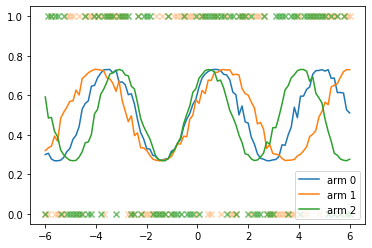

In [135]:
for arm in range(len(nonlinear_theta)):
    y = []
    p1s = []
    p2s= []
    optimal_y = []
    for i in range(num_data):
        outcome, p1, p2 = nccb.get_reward(arm, X_orig[i])
        p1s.append(p1)
        p2s.append(p2)
        y.append(outcome)

        optimal_y.append(nccb.get_reward(nccb.get_optimal_arm(X_orig[i]), X_orig[i])[0])
    y = np.array(y).flatten()

    plt.scatter(X_orig,y,alpha = arm/3, marker= 'x',)

    plt.plot(X_orig,p2s,label = f'arm {arm}')
    plt.legend()


In [136]:
nccb.get_optimal_arm(np.array([4.0])), nccb.get_optimal_arm(np.array([-9.0])), nccb.get_optimal_arm(np.array([-3.0]))

(2, 1, 2)

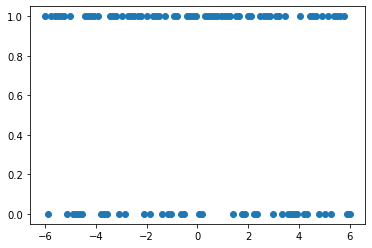

In [137]:
plt.scatter(X,np.array(optimal_y))

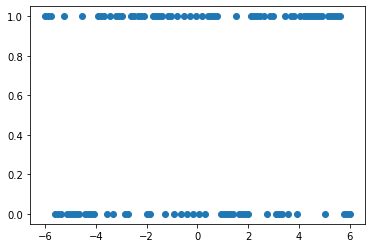

In [138]:
plt.scatter(X,np.array(y))

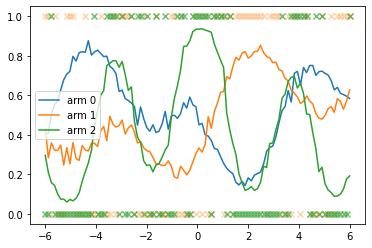

In [139]:
for arm in range(len(nonlinear_theta)):
    y = []
    p1s = []
    p2s= []
    optimal_y = []
    for i in range(num_data):
        context = X_multidimensional[:,i]

        outcome, p1, p2 = nccb.get_reward(arm, context)
        p1s.append(p1)
        p2s.append(p2)
        y.append(outcome)

        optimal_y.append(nccb.get_reward(nccb.get_optimal_arm(context), context)[0])
    y = np.array(y).flatten()

    plt.scatter(X_multidimensional[0,:],y,alpha = arm/3, marker= 'x',)

    plt.plot(X_multidimensional[0,:],p2s,label = f'arm {arm}')
    plt.legend()

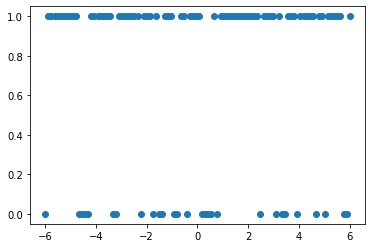

In [140]:
plt.scatter(X,np.array(optimal_y))

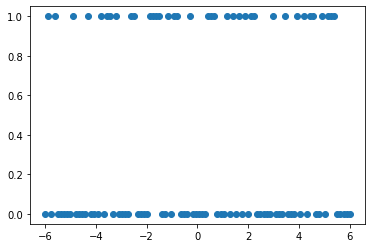

In [141]:
plt.scatter(X,np.array(y))

### cooperative

In [142]:
reward_75_percent = 0.1 * np.max(X)

def cooperative_MAB(arm1,arm2,context):
    
    if arm1 == arm2:
        return sigmoid(reward_75_percent)
    
    return sigmoid(context * arm1 *-.5 + context *arm2*.5)

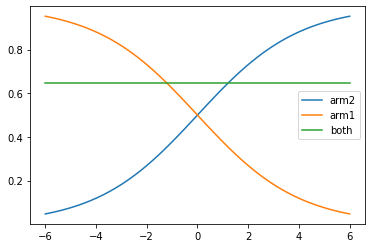

In [143]:
plt.plot(X_orig,[cooperative_MAB(0,1,x) for x in X_orig],label='arm2')
plt.plot(X_orig,[cooperative_MAB(1,0,x) for x in X_orig],label='arm1')
plt.plot(X_orig,[cooperative_MAB(0,0,x) for x in X_orig],label='both')

plt.legend()


## numerical


### contextual

In [28]:
#export
def contextual_numerical_bandit(context:np.array, choice:int, theta:np.array, noise=float)->float:
    features  = np.append(context,choice)

    # decide on which slope to use depending on whether a dog is present or not
    m = theta[0] if features[1] else theta[1]
    intercept = 0 if features[1] else 0

    # $y = x \cdot m + t + \epsilon $
    y = features[0] * m + intercept +  np.random.normal(0,noise)


    return y

In [29]:
contextual_numerical_bandit(np.array([1]),1,theta,noise)

0.12215452239010603

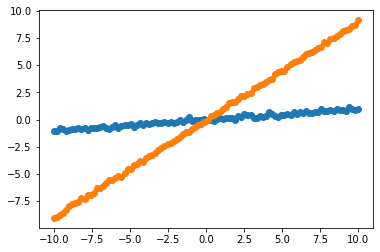

In [30]:
X = np.linspace(-10,10, num_data)
y0 = [contextual_numerical_bandit(x,0,theta,0.1) for x in X]
y1 = [contextual_numerical_bandit(x,1,theta,0.1) for x in X]

plt.scatter(X,y1)
plt.scatter(X,y0)


In [31]:
np.mean(y1), np.mean(y0)

(-0.0016854892075569494, -0.017693385391738748)

### nonlinear

In [ ]:
#export
class NonlinearContextualNumericalBandit(AbstractContextualMAB):
    
    def get_probability(self, choice, context):
        y = 0 #self.theta[choice]

        for dim in np.atleast_1d(context):
            y+= np.sin(self.theta[choice] * (dim+1)/2 + dim +  np.random.normal(0,self.noise))

        return self.activation(y)
    
    def get_reward(self, choice, context):
        p = self.get_probability(choice, context)
        return np.random.choice([0,1],p=[1-p,p]), max(self.theta) - p, p
    
    def get_optimal_arm(self, context):
        arm_ps = []
        for i in range(self.num_arms):
            arm_ps.append(self.get_probability(i, context))
            
        return np.argmax(arm_ps)

In [129]:
from nbdev.export import *
notebook2script()

Converted 00_abstractions.ipynb.
Converted 01_multi_armed_bandits.ipynb.
Converted 02_models.ipynb.
Converted 03_ensembles.ipynb.
Converted 04_solvers.ipynb.
Converted 10_adversarial_thompson_sampler.ipynb.
Converted 99_helpers.ipynb.
Converted contextual_bandits.ipynb.
Converted index.ipynb.
Converted noncontextual_bandits.ipynb.
Converted nonlinear_bandits.ipynb.
